# 环境导入与基本配置

In [10]:
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import warnings
import contextily as ctx
import xyzservices.providers as xyz

warnings.filterwarnings('ignore')  # 忽略无关警告，保持输出整洁

# 设置中文字体支持（解决matplotlib中文显示问题）
plt.rcParams["font.family"] = ["Times New Roman", "SimSun"]  # 英文字体为新罗马，中文字体为宋体
plt.rcParams["font.serif"] = ["Times New Roman", "SimSun"]  # 衬线字体
plt.rcParams["font.sans-serif"] = ["Times New Roman", "SimSun", "Arial", "SimHei"]  # 无衬线字体，与Latex相关
plt.rcParams["mathtext.fontset"] = "custom"

plt.rcParams['axes.unicode_minus'] = False

In [5]:


# 1. 定义研究区域（可替换为任意城市/区域，如"Beijing, China"）
place_name = "Manhattan, New York City"
print(f"正在从OpenStreetMap下载 '{place_name}' 的驾驶路网数据...")

# 2. 下载驾驶路网（network_type可选：drive/walk/bike/all）
G = ox.graph_from_place(place_name, network_type='drive')
print(f"路网下载完成！图结构统计：")
print(f"- 节点数量：{G.number_of_nodes()}")
print(f"- 边数量：{G.number_of_edges()}")

# 3. 投影转换（将经纬度坐标系转为UTM坐标系，使长度单位为"米"）
G_proj = ox.project_graph(G)



正在从OpenStreetMap下载 'Manhattan, New York City' 的驾驶路网数据...
路网下载完成！图结构统计：
- 节点数量：4619
- 边数量：9900


# 1. 路网密度

## 路网密度分析与持久化储存
- 考虑到上面函数计算耗时巨大，所以进行持久化存储
- 存储类型包括shp，geojson，gpkg

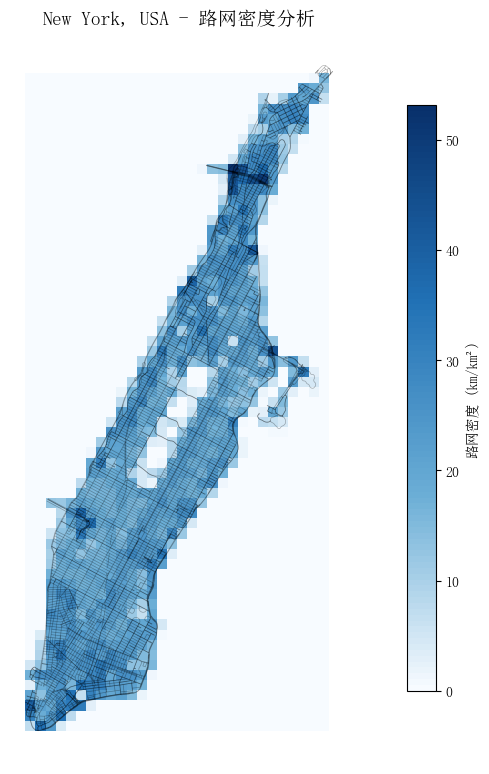

路网密度统计 (排除空网格):
  有效网格数量: 694 / 1950
  最小值: 0.11 km/km²
  最大值: 53.12 km/km²
  平均值: 18.77 km/km²
  中位数: 19.74 km/km²
  标准差: 8.41 km/km²


In [ ]:
def analyze_network_density_and_blocks(G, place_name, grid_size=300):
    """
    分析路网密度 - 以网格为单位计算路网密度，并持久化存储结果
    """
    # 首先将图转换为投影坐标系（UTM）
    G_proj = ox.project_graph(G)
    
    # 获取路网的边界
    bounds = ox.graph_to_gdfs(G_proj, nodes=False).total_bounds  # west, south, east, north
    
    # 创建网格
    west, south, east, north = bounds
    x_coords = np.arange(west, east, grid_size)
    y_coords = np.arange(south, north, grid_size)
    
    # 计算每个网格的路网密度
    road_densities = []
    grid_polygons = []
    
    # 将图转换为GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G_proj)
    
    # 确保几何类型是LineString或MultiLineString
    edges = edges[edges.geometry.type.isin(['LineString', 'MultiLineString'])]
    
    for i in range(len(x_coords)-1):
        for j in range(len(y_coords)-1):
            # 创建网格多边形
            poly = Polygon([
                (x_coords[i], y_coords[j]),
                (x_coords[i+1], y_coords[j]),
                (x_coords[i+1], y_coords[j+1]),
                (x_coords[i], y_coords[j+1])
            ])
            
            total_road_length_in_grid = 0
            
            # 对每条道路计算与网格的交集长度
            for idx, road in edges.iterrows():
                try:
                    # 计算道路与网格的交集
                    intersection = road.geometry.intersection(poly)
                    
                    if not intersection.is_empty:
                        # 计算交集部分的长度
                        if intersection.geom_type == 'LineString':
                            total_road_length_in_grid += intersection.length
                        elif intersection.geom_type == 'MultiLineString':
                            for line in intersection.geoms:
                                total_road_length_in_grid += line.length
                except Exception as e:
                    # 处理可能的几何错误
                    continue
            
            # 计算路网密度 (km/km²)
            grid_area = grid_size * grid_size / 1000000  # 转换为平方公里
            road_density = total_road_length_in_grid / 1000 / grid_area  # 公里/平方公里
            
            road_densities.append(road_density)
            grid_polygons.append(poly)
    
    # 创建路网密度GeoDataFrame
    grid_gdf = gpd.GeoDataFrame({'density': road_densities}, 
                               geometry=grid_polygons, crs=edges.crs)
    
    # 转回WGS84坐标系
    grid_gdf_wgs84 = grid_gdf.to_crs('EPSG:4326')
    
    # 生成文件名（包含网格大小和区域名称）
    place_name_clean = place_name.replace(', ', '_').replace(' ', '_')
    filename_base = f"road_density_{grid_size}m_{place_name_clean}"
    
    # 保存为GeoPackage
    gpkg_filename = f"{filename_base}.gpkg"
    grid_gdf_wgs84.to_file(gpkg_filename, layer='road_density', driver='GPKG')
    print(f"路网密度数据已保存为GeoPackage: {gpkg_filename}")
    
    # 保存为GeoJSON
    geojson_filename = f"{filename_base}.geojson"
    grid_gdf_wgs84.to_file(geojson_filename, driver='GeoJSON')
    print(f"路网密度数据已保存为GeoJSON: {geojson_filename}")
    
    # 打印统计信息
    non_zero_density = grid_gdf_wgs84[grid_gdf_wgs84['density'] > 0]['density']
    
    print(f"路网密度统计 (排除空网格):")
    print(f"  有效网格数量: {len(non_zero_density)} / {len(grid_gdf_wgs84)}")
    print(f"  最小值: {non_zero_density.min():.2f} km/km²")
    print(f"  最大值: {non_zero_density.max():.2f} km/km²")
    print(f"  平均值: {non_zero_density.mean():.2f} km/km²")
    print(f"  中位数: {non_zero_density.median():.2f} km/km²")
    print(f"  标准差: {non_zero_density.std():.2f} km/km²")
    
    return grid_gdf_wgs84

# 使用示例
grid_density = analyze_network_density_and_blocks(G, grid_size=300, place_name="New York, USA")


## 路网密度可视化展示

可视化结果已保存为: road_density_visualization_New_York,_USA.png


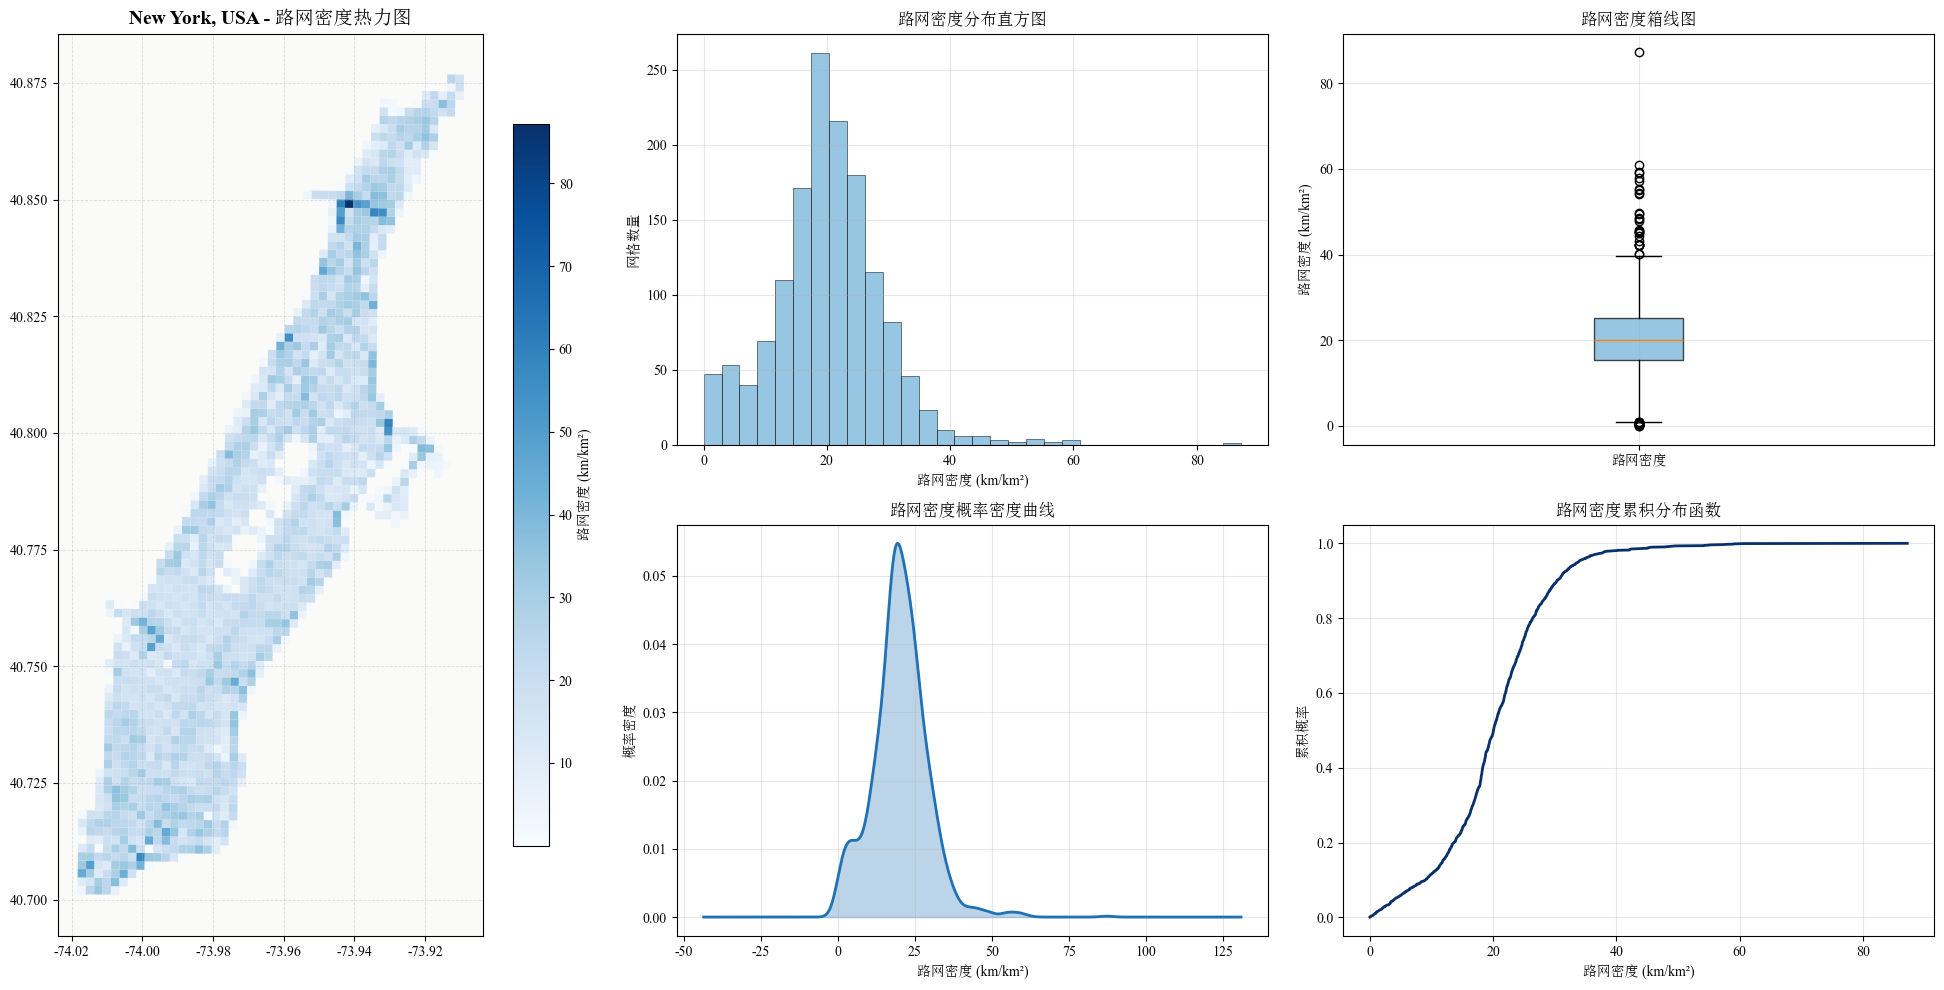


New York, USA - 路网密度详细统计分析
总网格数量: 4410
有效网格数量 (密度>0): 1450
空网格数量: 2960
空网格比例: 67.1%

路网密度统计 (排除空网格):
  最小值: 0.02 km/km²
  最大值: 87.21 km/km²
  平均值: 20.24 km/km²
  中位数: 20.07 km/km²
  标准差: 8.97 km/km²
  偏度: 0.660
  峰度: 3.511

分位数统计:
  10%分位数: 9.07 km/km²
  25%分位数: 15.49 km/km²
  50%分位数: 20.07 km/km²
  75%分位数: 25.14 km/km²
  90%分位数: 30.38 km/km²

密度等级分布:
  极低(0-5): 85个网格 (5.9%)
  低(5-10): 81个网格 (5.6%)
  中(10-15): 175个网格 (12.1%)
  高(15-20): 376个网格 (25.9%)
  极高(>20): 733个网格 (50.6%)


In [17]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

def visualize_road_density(gdf_path, place_name):
    """
    可视化路网密度分析结果
    """
    # 读取数据
    grid_gdf = gpd.read_file(gdf_path)
    
    # 过滤掉密度为0的网格用于统计分析
    non_zero_density = grid_gdf[grid_gdf['density'] > 0]['density']

    # 创建图形
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # 左侧：热力图
    ax1 = fig.add_subplot(gs[:, 0])  # 占据左侧全部
    
    # 创建自定义颜色映射
    colors = ['#f7fbff', '#6baed6', '#2171b5', '#08306b']
    cmap = plt.cm.get_cmap('Blues')
    
    # 绘制热力图
    none_zero=grid_gdf[grid_gdf['density'] > 0]
    none_zero.to_crs("EPSG:4326", inplace=True)
    none_zero.plot(column='density', cmap=cmap, ax=ax1, legend=True,
                 legend_kwds={'label': '路网密度 (km/km²)', 'shrink': 0.8})
    
    ax1.set_title(f'{place_name} - 路网密度热力图', fontsize=14, fontweight='bold')
    # 添加经纬度网格
    ax1.grid(True, alpha=0.4, linestyle='--', color='#A0AEC0', linewidth=0.6)
    ax1.get_xaxis().set_visible(True)
    ax1.get_yaxis().set_visible(True)
    ax1.set_axis_on()
    ax1.set_facecolor('#FAFAF8')
    # 右侧：统计图表
    # 直方图
    ax2 = fig.add_subplot(gs[0, 1])
    n, bins, patches = ax2.hist(non_zero_density, bins=30, alpha=0.7, color='#6baed6', 
                               edgecolor='black', linewidth=0.5)
    ax2.set_title('路网密度分布直方图', fontsize=12, fontweight='bold')
    ax2.set_xlabel('路网密度 (km/km²)')
    ax2.set_ylabel('网格数量')
    ax2.grid(True, alpha=0.3)
    
    # 箱线图
    ax3 = fig.add_subplot(gs[0, 2])
    box_data = [non_zero_density.values]
    box_plot = ax3.boxplot(box_data, patch_artist=True, labels=['路网密度'])
    # 设置箱线图颜色
    for patch in box_plot['boxes']:
        patch.set_facecolor('#6baed6')
        patch.set_alpha(0.7)
    ax3.set_title('路网密度箱线图', fontsize=12, fontweight='bold')
    ax3.set_ylabel('路网密度 (km/km²)')
    ax3.grid(True, alpha=0.3)
    
    # 密度曲线图
    ax4 = fig.add_subplot(gs[1, 1])
    density_curve = non_zero_density.plot.kde(ax=ax4, color='#2171b5', linewidth=2)
    ax4.set_title('路网密度概率密度曲线', fontsize=12, fontweight='bold')
    ax4.set_xlabel('路网密度 (km/km²)')
    ax4.set_ylabel('概率密度')
    ax4.grid(True, alpha=0.3)
    # 填充曲线下方区域
    x = density_curve.lines[0].get_xdata()
    y = density_curve.lines[0].get_ydata()
    ax4.fill_between(x, y, alpha=0.3, color='#2171b5')
    
    # 累积分布图
    ax5 = fig.add_subplot(gs[1, 2])
    sorted_data = np.sort(non_zero_density)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax5.plot(sorted_data, cdf, linewidth=2, color='#08306b')
    ax5.set_title('路网密度累积分布函数', fontsize=12, fontweight='bold')
    ax5.set_xlabel('路网密度 (km/km²)')
    ax5.set_ylabel('累积概率')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图片
    output_filename = f"road_density_visualization_{place_name.replace(' ', '_')}.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"可视化结果已保存为: {output_filename}")
    
    plt.show()
    
    # 打印详细统计信息
    print(f"\n{place_name} - 路网密度详细统计分析")
    print("=" * 50)
    print(f"总网格数量: {len(grid_gdf)}")
    print(f"有效网格数量 (密度>0): {len(non_zero_density)}")
    print(f"空网格数量: {len(grid_gdf) - len(non_zero_density)}")
    print(f"空网格比例: {(len(grid_gdf) - len(non_zero_density)) / len(grid_gdf) * 100:.1f}%")
    print("\n路网密度统计 (排除空网格):")
    print(f"  最小值: {non_zero_density.min():.2f} km/km²")
    print(f"  最大值: {non_zero_density.max():.2f} km/km²")
    print(f"  平均值: {non_zero_density.mean():.2f} km/km²")
    print(f"  中位数: {non_zero_density.median():.2f} km/km²")
    print(f"  标准差: {non_zero_density.std():.2f} km/km²")
    print(f"  偏度: {non_zero_density.skew():.3f}")
    print(f"  峰度: {non_zero_density.kurtosis():.3f}")
    
    # 分位数统计
    print("\n分位数统计:")
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    for q in quantiles:
        value = non_zero_density.quantile(q)
        print(f"  {int(q*100)}%分位数: {value:.2f} km/km²")
    
    # 密度等级统计
    print("\n密度等级分布:")
    density_bins = [0, 5, 10, 15, 20, float('inf')]
    density_labels = ['极低(0-5)', '低(5-10)', '中(10-15)', '高(15-20)', '极高(>20)']
    
    for i in range(len(density_bins)-1):
        if i == len(density_bins)-2:  # 最后一个区间
            count = len(non_zero_density[non_zero_density >= density_bins[i]])
        else:
            count = len(non_zero_density[(non_zero_density >= density_bins[i]) & 
                                       (non_zero_density < density_bins[i+1])])
        percentage = count / len(non_zero_density) * 100
        print(f"  {density_labels[i]}: {count}个网格 ({percentage:.1f}%)")

# 使用示例
visualize_road_density(r"D:\必须用电脑解决的作业\地理大数据分析\实习三\实习三代码\new_york_road_density.gpkg", "New York, USA")



In [ ]:
def density_visualization(file_path: str):
    """
    根据持久化存储的密度数据进行可视化
    1、
    """